In [228]:
import numpy as np
import random
import pandas as pd 
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

from pandas import datetime
import math, time
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable


C:\Users\Admin\AppData\Local\Temp\ipykernel_18476\716880161.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
C:\Users\Admin\AppData\Local\Temp\ipykernel_18476\716880161.py:9: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [250]:
data= pd.read_csv(r"C:\Users\Admin\Downloads\USDJPY_D1.csv")
data.head()

,2008-05-08 00:00,104.68,104.95,103.4,103.98,863662
0,2008-05-09 00:00,103.98,104.090,102.610,102.890,446157
1,2008-05-12 00:00,103.01,104.030,102.570,103.815,217812
2,2008-05-13 00:00,103.82,104.820,103.385,104.755,370753
3,2008-05-14 00:00,104.75,105.440,104.565,105.300,209752
4,2008-05-15 00:00,105.31,105.355,104.425,104.820,536075


In [251]:
data.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

In [252]:
data["Date"]=pd.to_datetime(data["Date"])

In [253]:
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4185 entries, 0 to 4184
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    4185 non-null   datetime64[ns]
 1   Open    4185 non-null   float64       
 2   High    4185 non-null   float64       
 3   Low     4185 non-null   float64       
 4   Close   4185 non-null   float64       
 5   Volume  4185 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 196.3 KB


In [254]:
df = pd.DataFrame(data[['Date', 'Close']])

In [255]:
df=df[df["Date"].between('2010-01-02','2017-10-11')]
df=df.set_index("Date")

In [256]:
df.head()

,Close
Date,
2010-01-04,92.615
2010-01-05,91.510
2010-01-06,92.585
2010-01-07,93.250
2010-01-08,92.580


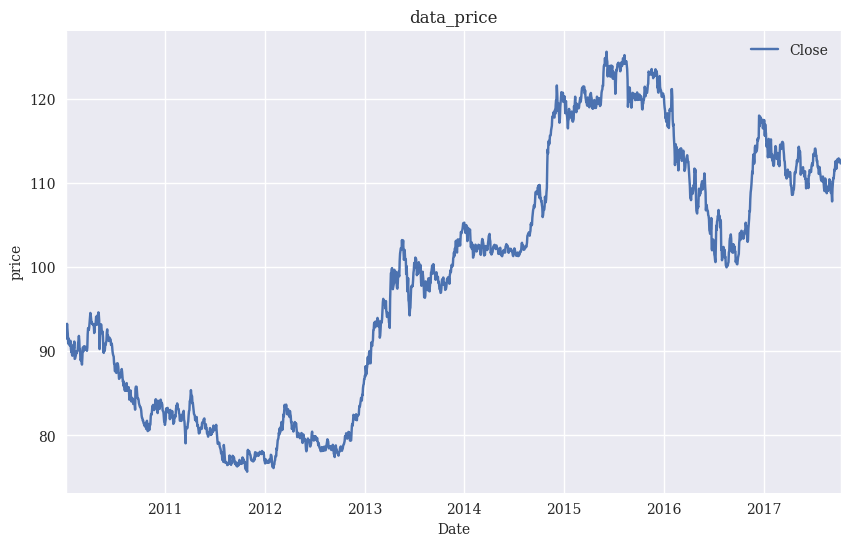

In [257]:
df.plot(figsize=(10, 6), subplots=True)
plt.ylabel("price")
plt.title("data_price")
plt.show()

In [258]:
scaler = MinMaxScaler(feature_range=(-1, 1))
df['Close'] = scaler.fit_transform(df['Close'].values.reshape(-1,1))

In [259]:
df.shape[0]

2028

In [260]:
def load_data(stock, look_back):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back):
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

look_back =60 # choose sequence length
x_train, y_train, x_test, y_test = load_data(df, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (1574, 59, 1)
y_train.shape =  (1574, 1)
x_test.shape =  (394, 59, 1)
y_test.shape =  (394, 1)


In [261]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [262]:
y_train.size(),x_train.size()

(torch.Size([1574, 1]), torch.Size([1574, 59, 1]))

# Build the structure of model

In [263]:
# Build model
#####################
input_dim = 1
hidden_dim = 32
num_layers = 2 
output_dim = 1

In [264]:

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out
    
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


In [265]:
# Train model
#####################
num_epochs = 450
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1  

for t in range(num_epochs):
    
    
    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.06251759827136993
Epoch  20 MSE:  0.014219417236745358
Epoch  30 MSE:  0.0024782237596809864
Epoch  40 MSE:  0.0017950549954548478
Epoch  50 MSE:  0.001586072496138513
Epoch  60 MSE:  0.0012433978263288736
Epoch  70 MSE:  0.0011650130618363619
Epoch  80 MSE:  0.0011492781341075897
Epoch  90 MSE:  0.0011224214686080813
Epoch  100 MSE:  0.0010959604987874627
Epoch  110 MSE:  0.001073459512554109
Epoch  120 MSE:  0.0010532154701650143
Epoch  130 MSE:  0.0010338826104998589
Epoch  140 MSE:  0.0010153594193980098
Epoch  150 MSE:  0.0009976697620004416
Epoch  160 MSE:  0.0009808188769966364
Epoch  170 MSE:  0.0009648323757573962
Epoch  180 MSE:  0.0009497184655629098
Epoch  190 MSE:  0.0009354670764878392
Epoch  200 MSE:  0.0009220478241331875
Epoch  210 MSE:  0.0009094103588722646
Epoch  220 MSE:  0.0008974865195341408
Epoch  230 MSE:  0.000886196328792721
Epoch  240 MSE:  0.0008754524169489741
Epoch  250 MSE:  0.0008651678799651563
Epoch  260 MSE:  0.0008552593062631786
E

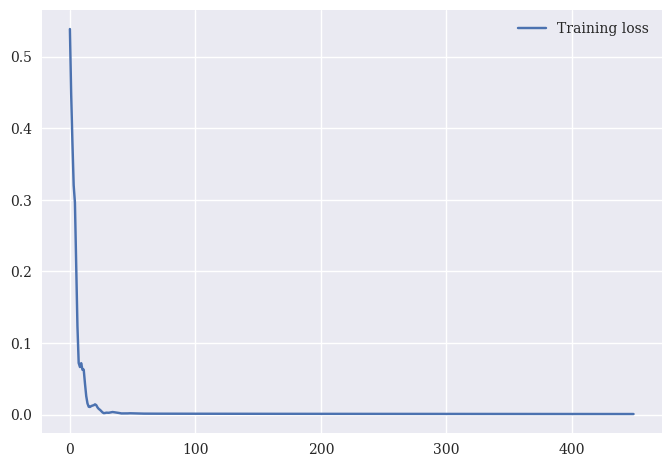

In [266]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [267]:
np.shape(y_train_pred)

torch.Size([1574, 1])

In [268]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.66 RMSE
Test Score: 0.85 RMSE


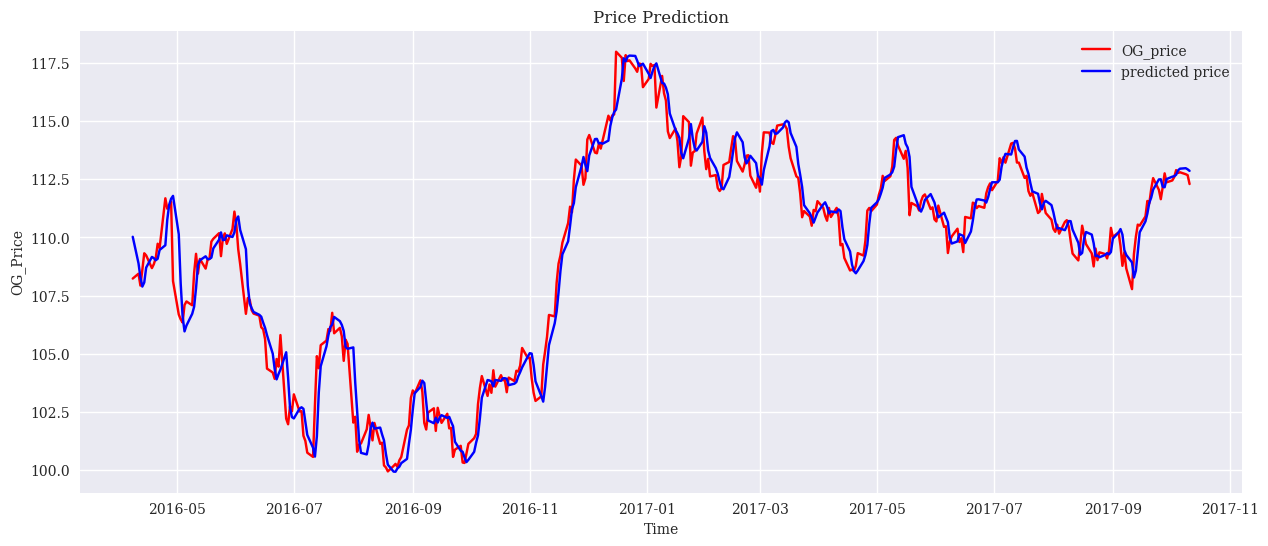

In [269]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(df[len(df)-len(y_test):].index, y_test, color = 'red', label = 'OG_price')
axes.plot(df[len(df)-len(y_test):].index, y_test_pred, color = 'blue', label = 'predicted price')
#axes.xticks(np.arange(0,394,50))
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('OG_Price')
plt.legend()
plt.savefig('PRICE_pred.png')
plt.show()